# tools for pre-processing images

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '1.0'
__keywords__ = ['astronomy', 'astropy', 'astroalign', 'ccdproc', 'matplotlib']


## configure display

In [3]:
### allow full width of browser
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

### matplotlib settings
import matplotlib.pyplot as plt

%config InlineBackend.rc = {}
plt.style.use(['dark_background'])
plt.rcParams.update({'figure.max_open_warning': 0}) 

### set the mpl backend
#%matplotlib widget
%matplotlib inline


## import libraries

In [4]:
import fnmatch, os
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from ccdproc import ImageFileCollection, cosmicray_median, cosmicray_lacosmic, gain_correct
from convenience_functions import show_image
from easycombiner import Images


## define targets - required keywords : 
```
TARGET = name of object, used for naming generated files
CAPTURE_DIR = directory with ending /
BIAS_FILES = wildcard bias files names (wild cards)
DARK_FILES = wildcard dark files names (wild cards)
FLAT_FILES = wildcard flat files names (wild cards)
CALIB_FILES = wildcard neon files names (wild cards)
SCIENCE_FILES = wildcard science files names (wild cards)
TRIM_REGION = x1, y1, x2, y2 region to crop before processing
EXPOSURE_KEY = fit keyword defining 'EXPOSURE'
camera_electronic_gain = 0.13 * u.electron/u.adu   # atik 420m - 0.024 asi183mm
camera_readout_noise = 3.0 * u.electron     # atik 420m - 2.8 asi183mm


In [5]:
TARGET = 'v558-Lyr'
CAPTURE_DIR='../../../CAPTURES/20240928_Void/'
BIAS_FILES = "Bias-*.fit"
DARK_FILES = "Dark-600s-*.fit"
FLAT_FILES = "flat_tung*.fit"
CALIB_FILES = "neon-*.fit"
SCIENCE_FILES = "v558_Lyr-*.fit"
TRIM_REGION = '0, 1000, 5496, 2500'              # x1, y1, x2, y2 
#TRIM_REGION = None
EXPOSURE_KEY = 'EXPTIME'
camera_electronic_gain = 0.024 * u.electron/u.adu   
camera_readout_noise = 2.8 * u.electron     


## define logger

In [6]:
### logger prints after every notebook cell
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')


## create masterbias

2024-10-02 18:34:26 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.766781 from DATE-OBS'.


2024-10-02 18:34:27 [INFO] - image : ../../../CAPTURES/20240928_Void/Bias-0s-120-20-1.fit loaded
2024-10-02 18:34:27 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.766872 from DATE-OBS'.


2024-10-02 18:34:27 [INFO] - image : ../../../CAPTURES/20240928_Void/Bias-0s-120-20-2.fit loaded
2024-10-02 18:34:27 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.766962 from DATE-OBS'.


2024-10-02 18:34:28 [INFO] - image : ../../../CAPTURES/20240928_Void/Bias-0s-120-20-3.fit loaded
2024-10-02 18:34:28 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.767051 from DATE-OBS'.


2024-10-02 18:34:28 [INFO] - image : ../../../CAPTURES/20240928_Void/Bias-0s-120-20-4.fit loaded
2024-10-02 18:34:28 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.767141 from DATE-OBS'.


2024-10-02 18:34:28 [INFO] - image : ../../../CAPTURES/20240928_Void/Bias-0s-120-20-5.fit loaded
2024-10-02 18:34:29 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.767230 from DATE-OBS'.


2024-10-02 18:34:29 [INFO] - image : ../../../CAPTURES/20240928_Void/Bias-0s-120-20-6.fit loaded
2024-10-02 18:34:29 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.767320 from DATE-OBS'.


2024-10-02 18:34:29 [INFO] - image : ../../../CAPTURES/20240928_Void/Bias-0s-120-20-7.fit loaded
2024-10-02 18:34:29 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.767409 from DATE-OBS'.


2024-10-02 18:34:30 [INFO] - image : ../../../CAPTURES/20240928_Void/Bias-0s-120-20-8.fit loaded
2024-10-02 18:34:30 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.767498 from DATE-OBS'.


2024-10-02 18:34:31 [INFO] - image : ../../../CAPTURES/20240928_Void/Bias-0s-120-20-9.fit loaded
2024-10-02 18:34:31 [INFO] - 9 images trimmed to (0, 1000, 5496, 2500)
2024-10-02 18:34:31 [INFO] - median combine on 9 images ...
INFO: splitting each image into 4 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]
2024-10-02 18:34:31 [INFO] - splitting each image into 4 chunks to limit memory usage to 1000000000.0 bytes.
2024-10-02 18:34:40 [INFO] - min=944.0 adu, max=1856.0 adu, avg=1352.2511 adu
2024-10-02 18:34:40 [WARNING] - The following attributes were set on the data object, but will be ignored by the function: uncertainty, mask, meta, unit


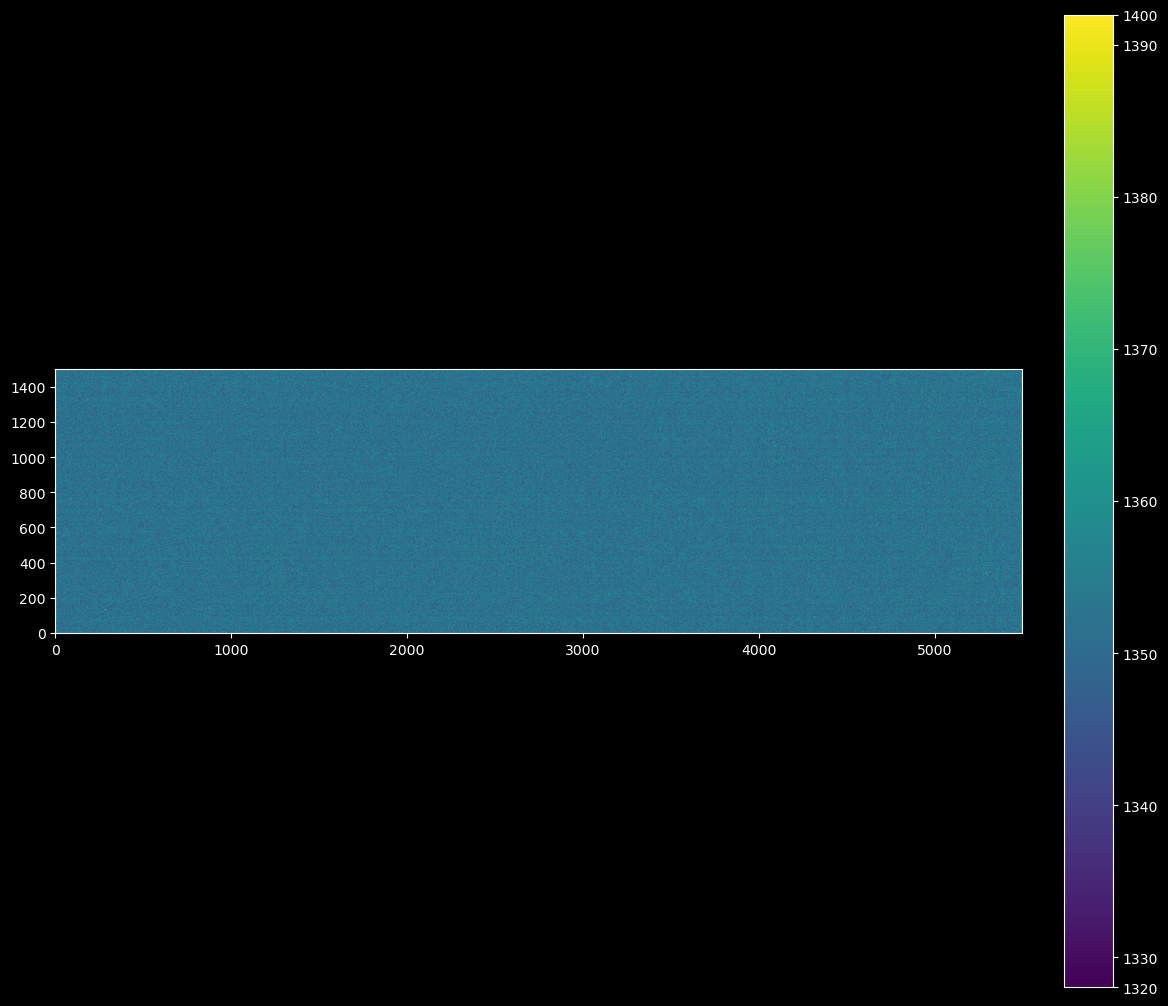

In [7]:
### create master bias
if (BIAS_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterbias.fit')):
    master_bias = Images.from_fit(dir = CAPTURE_DIR, filter = BIAS_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .median() 
                        #.sigmaclip() 
                        #.offset(1500 * u.adu) \
    master_bias.write(CAPTURE_DIR + 'masterbias.fit', overwrite=True) 
    logger.info(f'min={master_bias.min()}, max={master_bias.max()}, avg={master_bias.mean()}')
    show_image(image = master_bias, figsize=(50, ),) #, percl = 0, percu = 95)


## create masterdark

2024-10-02 18:34:41 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.839780 from DATE-OBS'.


2024-10-02 18:34:42 [INFO] - image : ../../../CAPTURES/20240928_Void/Dark-600s-120-20-1.fit loaded
2024-10-02 18:34:42 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.846772 from DATE-OBS'.


2024-10-02 18:34:42 [INFO] - image : ../../../CAPTURES/20240928_Void/Dark-600s-120-20-2.fit loaded
2024-10-02 18:34:42 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.853761 from DATE-OBS'.


2024-10-02 18:34:42 [INFO] - image : ../../../CAPTURES/20240928_Void/Dark-600s-120-20-3.fit loaded
2024-10-02 18:34:42 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.860755 from DATE-OBS'.


2024-10-02 18:34:43 [INFO] - image : ../../../CAPTURES/20240928_Void/Dark-600s-120-20-4.fit loaded
2024-10-02 18:34:43 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.867752 from DATE-OBS'.


2024-10-02 18:34:43 [INFO] - image : ../../../CAPTURES/20240928_Void/Dark-600s-120-20-5.fit loaded
2024-10-02 18:34:43 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.874746 from DATE-OBS'.


2024-10-02 18:34:43 [INFO] - image : ../../../CAPTURES/20240928_Void/Dark-600s-120-20-6.fit loaded
2024-10-02 18:34:43 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.881743 from DATE-OBS'.


2024-10-02 18:34:44 [INFO] - image : ../../../CAPTURES/20240928_Void/Dark-600s-120-20-7.fit loaded
2024-10-02 18:34:44 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.888730 from DATE-OBS'.


2024-10-02 18:34:44 [INFO] - image : ../../../CAPTURES/20240928_Void/Dark-600s-120-20-8.fit loaded
2024-10-02 18:34:44 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.895726 from DATE-OBS'.


2024-10-02 18:34:45 [INFO] - image : ../../../CAPTURES/20240928_Void/Dark-600s-120-20-9.fit loaded
2024-10-02 18:34:46 [INFO] - 9 images trimmed to (0, 1000, 5496, 2500)
2024-10-02 18:34:47 [INFO] - masterbias substracted to 9 images
2024-10-02 18:34:47 [INFO] - median combine on 9 images ...
INFO: splitting each image into 4 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]
2024-10-02 18:34:47 [INFO] - splitting each image into 4 chunks to limit memory usage to 1000000000.0 bytes.
2024-10-02 18:34:57 [INFO] - min=-480.0 adu, max=64160.0 adu, avg=42.644215 adu
2024-10-02 18:34:57 [WARNING] - The following attributes were set on the data object, but will be ignored by the function: uncertainty, mask, meta, unit


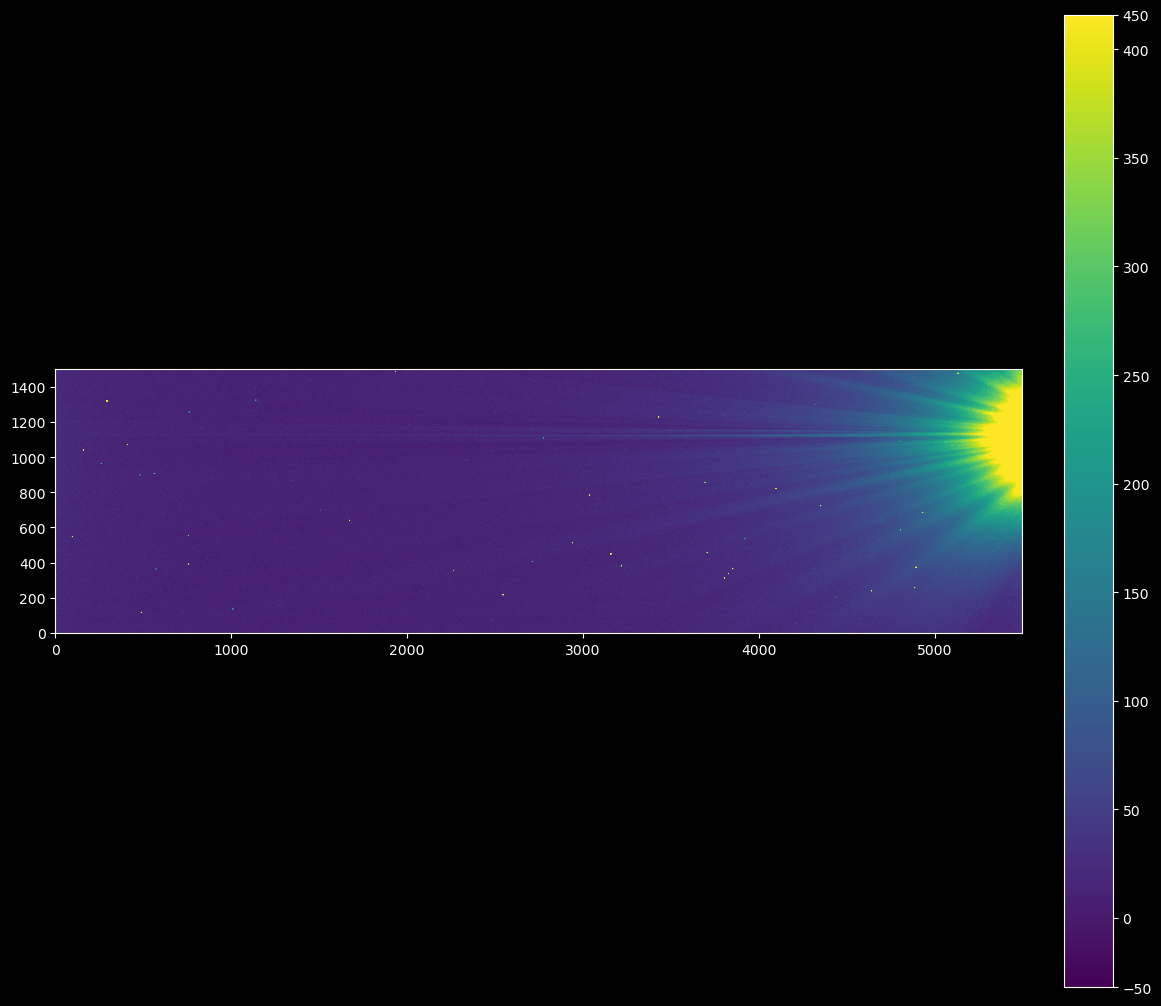

In [8]:
### create master dark
if (DARK_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterdark.fit')):
    master_dark = Images.from_fit(dir = CAPTURE_DIR, filter = DARK_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .bias_substract(master_bias) \
                        .median() 
                        #.sigmaclip() 
                        #.offset(1500 * u.adu) \
    master_dark.write(CAPTURE_DIR + 'masterdark.fit', overwrite=True) 
    logger.info(f'min={master_dark.min()}, max={master_dark.max()}, avg={master_dark.mean()}')
    show_image(image = master_dark,  figsize=(50, ))


## create masterflat

2024-10-02 18:34:58 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.681127 from DATE-OBS'.


2024-10-02 18:34:59 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-1.fit loaded
2024-10-02 18:34:59 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.681348 from DATE-OBS'.


2024-10-02 18:34:59 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-2.fit loaded
2024-10-02 18:34:59 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.681566 from DATE-OBS'.


2024-10-02 18:34:59 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-3.fit loaded
2024-10-02 18:34:59 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.681792 from DATE-OBS'.


2024-10-02 18:35:00 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-4.fit loaded
2024-10-02 18:35:00 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.682012 from DATE-OBS'.


2024-10-02 18:35:00 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-5.fit loaded
2024-10-02 18:35:00 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.682236 from DATE-OBS'.


2024-10-02 18:35:01 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-6.fit loaded
2024-10-02 18:35:01 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.682462 from DATE-OBS'.


2024-10-02 18:35:01 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-7.fit loaded
2024-10-02 18:35:01 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.682683 from DATE-OBS'.


2024-10-02 18:35:01 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-8.fit loaded
2024-10-02 18:35:02 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.682909 from DATE-OBS'.


2024-10-02 18:35:02 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-9.fit loaded
2024-10-02 18:35:02 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.683128 from DATE-OBS'.


2024-10-02 18:35:03 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-10.fit loaded
2024-10-02 18:35:03 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.683355 from DATE-OBS'.


2024-10-02 18:35:05 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-11.fit loaded
2024-10-02 18:35:05 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.683576 from DATE-OBS'.


2024-10-02 18:35:05 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-12.fit loaded
2024-10-02 18:35:06 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.683802 from DATE-OBS'.


2024-10-02 18:35:06 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-13.fit loaded
2024-10-02 18:35:06 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.684022 from DATE-OBS'.


2024-10-02 18:35:07 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-14.fit loaded
2024-10-02 18:35:07 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.684249 from DATE-OBS'.


2024-10-02 18:35:08 [INFO] - image : ../../../CAPTURES/20240928_Void/flat_tung_-15s-120-20-15.fit loaded
2024-10-02 18:35:09 [INFO] - 15 images trimmed to (0, 1000, 5496, 2500)
2024-10-02 18:35:12 [INFO] - masterbias substracted to 15 images
2024-10-02 18:35:12 [INFO] - sum combine on 15 images ...
INFO: splitting each image into 5 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]
2024-10-02 18:35:12 [INFO] - splitting each image into 5 chunks to limit memory usage to 1000000000.0 bytes.
2024-10-02 18:35:15 [INFO] - min=339600.0 adu, max=962400.0 adu, avg=397747.03 adu
2024-10-02 18:35:15 [WARNING] - The following attributes were set on the data object, but will be ignored by the function: uncertainty, mask, meta, unit


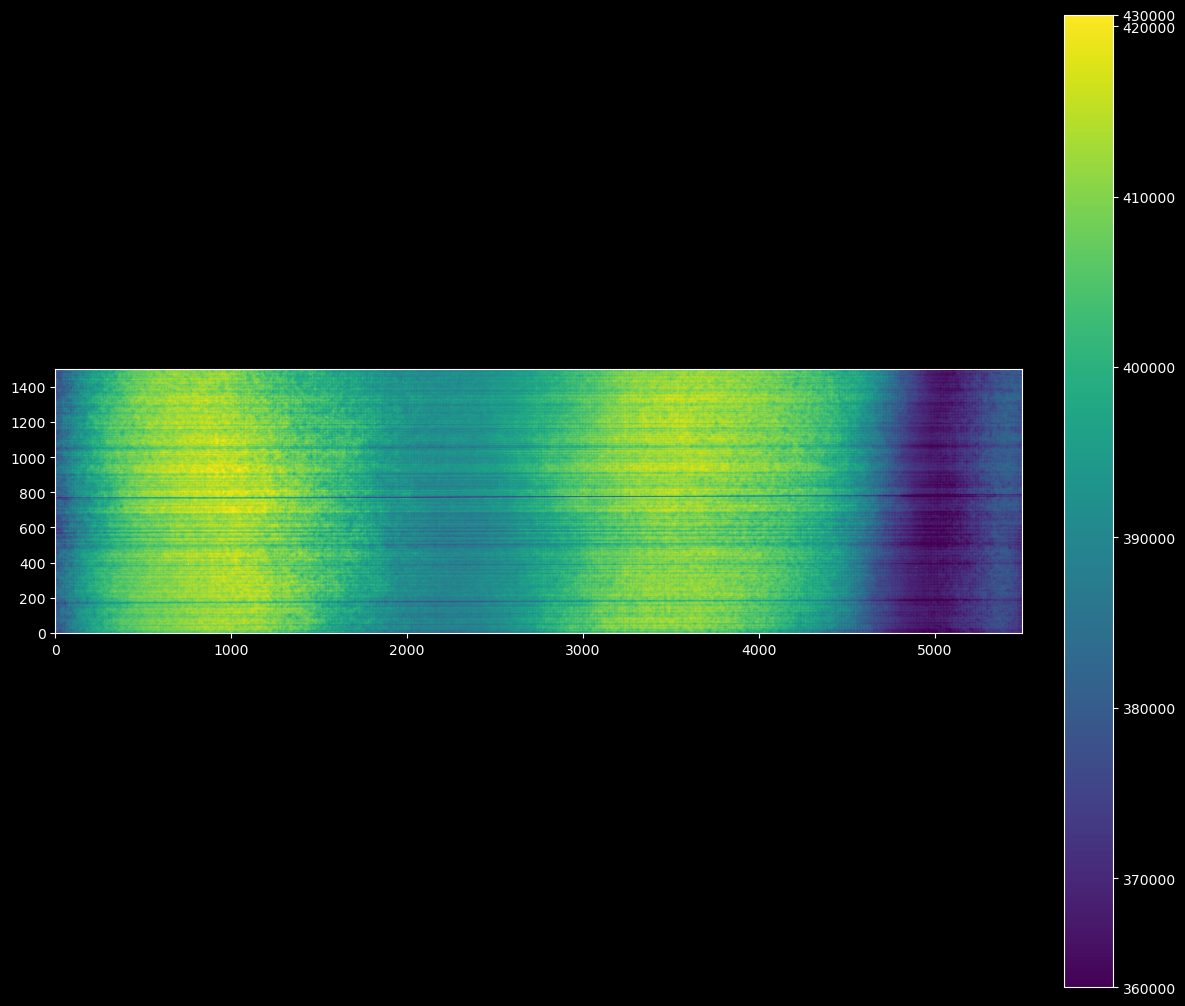

In [9]:
### create master flat
if (FLAT_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterflat.fit')):
    master_flat = Images.from_fit(dir = CAPTURE_DIR, filter = FLAT_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .bias_substract(master_bias) \
                        .sum()
#                        .median()
#                        .offset(1500 * u.adu) \
    master_flat.write(CAPTURE_DIR + 'masterflat.fit', overwrite=True) 
    logger.info(f'min={master_flat.min()}, max={master_flat.max()}, avg={master_flat.mean()}')
    show_image(image = master_flat,  figsize=(50, ))


## create mastercalib

2024-10-02 18:35:48 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60583.687917 from DATE-OBS'.


2024-10-02 18:35:49 [INFO] - image : ../../../CAPTURES/20240928_Void/neon-2s-120-20-1.fit loaded
2024-10-02 18:35:49 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60583.687978 from DATE-OBS'.


2024-10-02 18:35:49 [INFO] - image : ../../../CAPTURES/20240928_Void/neon-2s-120-20-2.fit loaded
2024-10-02 18:35:49 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60583.688036 from DATE-OBS'.


2024-10-02 18:35:49 [INFO] - image : ../../../CAPTURES/20240928_Void/neon-2s-120-20-3.fit loaded
2024-10-02 18:35:49 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60583.688097 from DATE-OBS'.


2024-10-02 18:35:50 [INFO] - image : ../../../CAPTURES/20240928_Void/neon-2s-120-20-4.fit loaded
2024-10-02 18:35:50 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60583.688157 from DATE-OBS'.


2024-10-02 18:35:50 [INFO] - image : ../../../CAPTURES/20240928_Void/neon-2s-120-20-5.fit loaded
2024-10-02 18:35:50 [INFO] - 5 images trimmed to (0, 1000, 5496, 2500)
2024-10-02 18:35:51 [INFO] - masterbias substracted to 5 images
2024-10-02 18:35:51 [INFO] - median combine on 5 images ...
INFO: splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]
2024-10-02 18:35:51 [INFO] - splitting each image into 3 chunks to limit memory usage to 1000000000.0 bytes.
2024-10-02 18:35:57 [INFO] - min=-688.0 adu, max=7264.0 adu, avg=8.891969 adu
2024-10-02 18:35:57 [WARNING] - The following attributes were set on the data object, but will be ignored by the function: uncertainty, mask, meta, unit


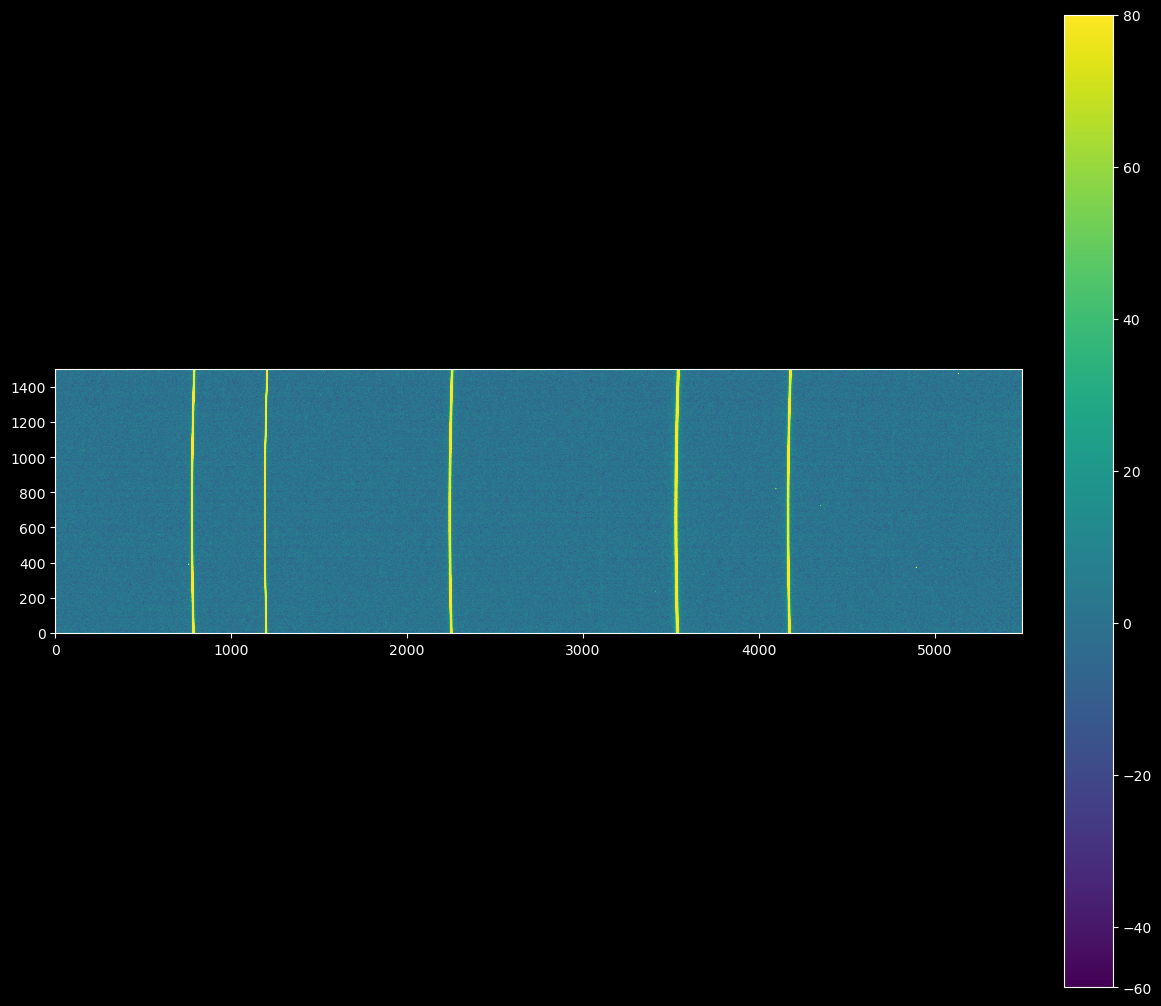

In [11]:
### create master calib
if (CALIB_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'mastercalib.fit')):
    master_calib = Images.from_fit(dir = CAPTURE_DIR, filter = CALIB_FILES,
                                   camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                         .trim(TRIM_REGION) \
                         .bias_substract(master_bias) \
                         .median()
                         #.sigmaclip()
#                         .offset(1500 * u.adu) \
    master_calib.write(CAPTURE_DIR + 'mastercalib.fit', overwrite=True) 
    logger.info(f'min={master_calib.min()}, max={master_calib.max()}, avg={master_calib.mean()}')
    show_image(image = master_calib ,figsize=(50, ))


## reduce science frames

2024-10-02 18:36:03 [INFO] - read refernce frames...
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-10-02 18:36:03 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-10-02 18:36:03 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.766781 from DATE-OBS'.
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-10-02 18:36:03 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-10-02 18:36:03 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60566.839780 from DATE-OBS'.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
2024-10-02 18:36:04 [INFO] - using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
2024-10-02 18:36:04 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60564.681127 from DATE-OBS'.
2024-10-02 18:36:04 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60581.868904 from DATE-OBS'.


2024-10-02 18:36:04 [INFO] - image : ../../../CAPTURES/20240928_Void/v558_Lyr-120-20-1.fit loaded
2024-10-02 18:36:04 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60581.875946 from DATE-OBS'.


2024-10-02 18:36:05 [INFO] - image : ../../../CAPTURES/20240928_Void/v558_Lyr-120-20-2.fit loaded
2024-10-02 18:36:05 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60581.882987 from DATE-OBS'.


2024-10-02 18:36:05 [INFO] - image : ../../../CAPTURES/20240928_Void/v558_Lyr-120-20-3.fit loaded
2024-10-02 18:36:05 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60581.890028 from DATE-OBS'.


2024-10-02 18:36:05 [INFO] - image : ../../../CAPTURES/20240928_Void/v558_Lyr-120-20-4.fit loaded
2024-10-02 18:36:05 [WARNING] - FITSFixedWarning: 'datfix' made the change 'Set MJD-OBS to 60581.897070 from DATE-OBS'.


2024-10-02 18:36:06 [INFO] - image : ../../../CAPTURES/20240928_Void/v558_Lyr-120-20-5.fit loaded
2024-10-02 18:36:06 [INFO] - 5 images trimmed to (0, 1000, 5496, 2500)
2024-10-02 18:36:13 [INFO] - 5 images reduced
2024-10-02 18:36:13 [INFO] - align: fftconvolve running...
2024-10-02 18:36:18 [INFO] - align: get max cross-correlation for every image...
2024-10-02 18:36:18 [INFO] - align: images deltas = [(0, 0), (0, 0), (0, 0), (0, 0)]
2024-10-02 18:36:18 [INFO] - align: images realignement ...
2024-10-02 18:36:18 [INFO] - align: complete
2024-10-02 18:36:18 [INFO] - frame 0: min=-9921.128 adu, max=63550.73 adu, avg=3.0575235 adu
2024-10-02 18:36:18 [INFO] - frame 1: min=-9426.526 adu, max=63550.73 adu, avg=2.8089135 adu
2024-10-02 18:36:18 [INFO] - frame 2: min=-11143.085 adu, max=63550.73 adu, avg=2.1417382 adu
2024-10-02 18:36:18 [INFO] - frame 3: min=-10808.501 adu, max=46188.44 adu, avg=2.8853211 adu
2024-10-02 18:36:19 [INFO] - frame 4: min=-9222.866 adu, max=63550.73 adu, avg=3.

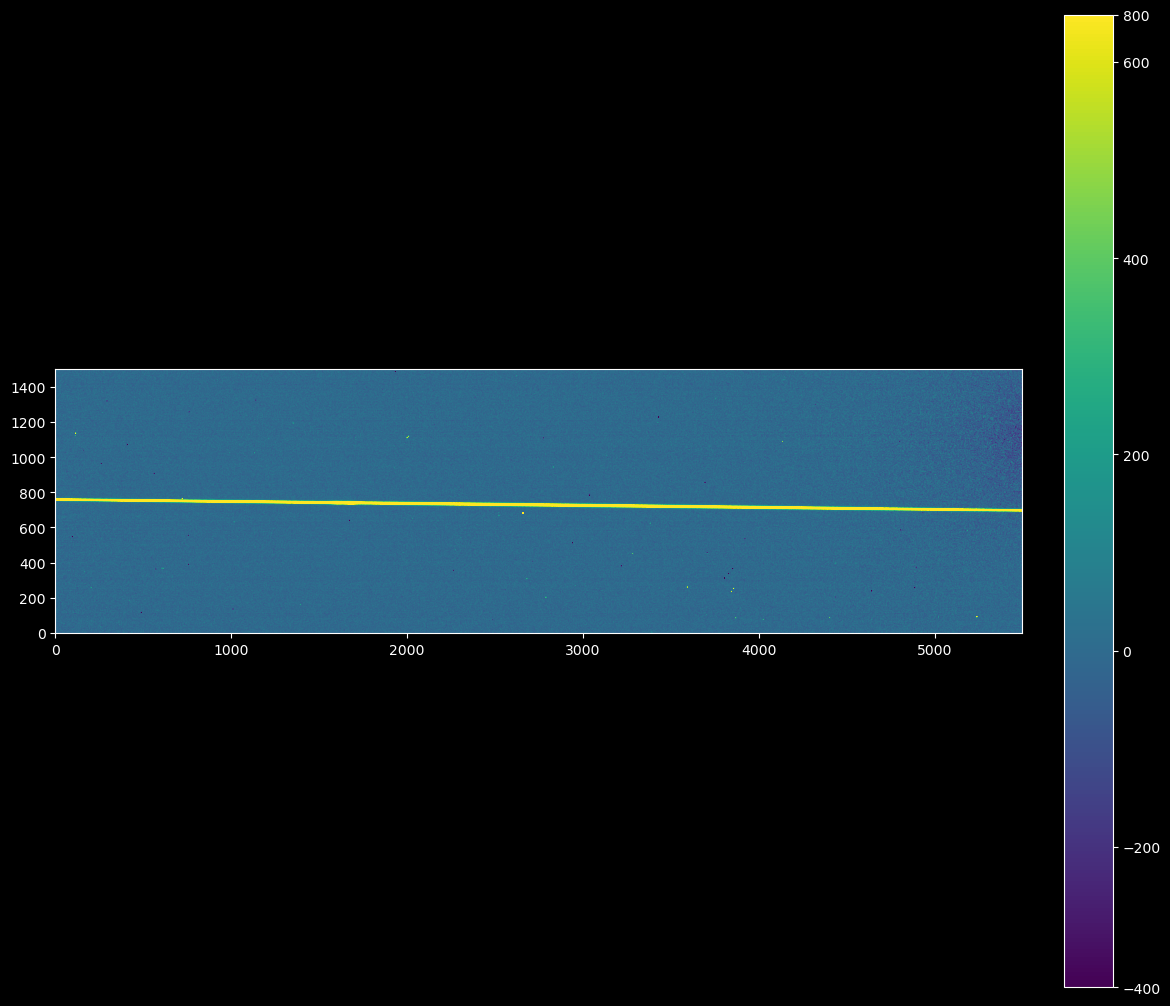

In [12]:
### read master reference frames
logger.info('read refernce frames...')

master_bias = CCDData.read(CAPTURE_DIR + 'masterbias.fit', unit = u.adu)
master_dark = CCDData.read(CAPTURE_DIR + 'masterdark.fit', unit = u.adu)
master_flat = CCDData.read(CAPTURE_DIR + 'masterflat.fit', unit = u.adu)

### reduce science frames
master_sciences = Images.from_fit(dir = CAPTURE_DIR, filter = SCIENCE_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .reduce(master_bias = master_bias, master_dark = master_dark, master_flat = master_flat, exposure_key = EXPOSURE_KEY) \
                        .spec_align(ref_image_index = 0)                        # fft based - best for spectra fields

#                        .star_align(ref_image_index = 0)                        # astro_align (triangles) based - best for stars fields
#                        .bias_substract(master_bias) \
#                        .dark_substract(master_dark, scale_exposure = True, exposure = EXPOSURE_KEY) \
#                        .flat_divide(master_flat) \
#                        .offset(1500 * u.adu) \

### optional: save individual frames
for i, frame in zip(range(0, len(master_sciences)), master_sciences):
    frame.write(f'{CAPTURE_DIR}{TARGET}-{i}-reduced.fit', overwrite=True)
    logger.info(f'frame {i}: min={frame.min()}, max={frame.max()}, avg={frame.mean()}')

### combine frames (sum or median) & save master science frame
master_science = master_sciences.sum() 
#master_science = master_sciences.median()

### update fits header
master_science.meta['EXPTIME2'] = f'{len(master_sciences)} x {master_science.meta[EXPOSURE_KEY]} s'
master_science.meta['EXPTIME'] = len(master_sciences) * master_science.meta[EXPOSURE_KEY]

master_science.write(f'{CAPTURE_DIR}{TARGET}-reduced.fit', overwrite=True)
logger.info(f'master_science: min={master_science.min()}, max={master_science.max()}, avg={master_science.mean()}')
show_image(image = master_science, figsize=(50, ))


## remove cosmics

2024-10-02 18:36:30 [INFO] - master_science: min=-50522.105 adu, max=300391.34 adu, avg=14.403476 adu
2024-10-02 18:36:31 [INFO] - gain_corrected: min=-1212.5305 electron, max=7209.392 electron, avg=0.3456831 electron
2024-10-02 18:36:35 [INFO] - master_science_clean: min=-161.43849 electron, max=70.46463 electron, avg=-0.62564576 electron


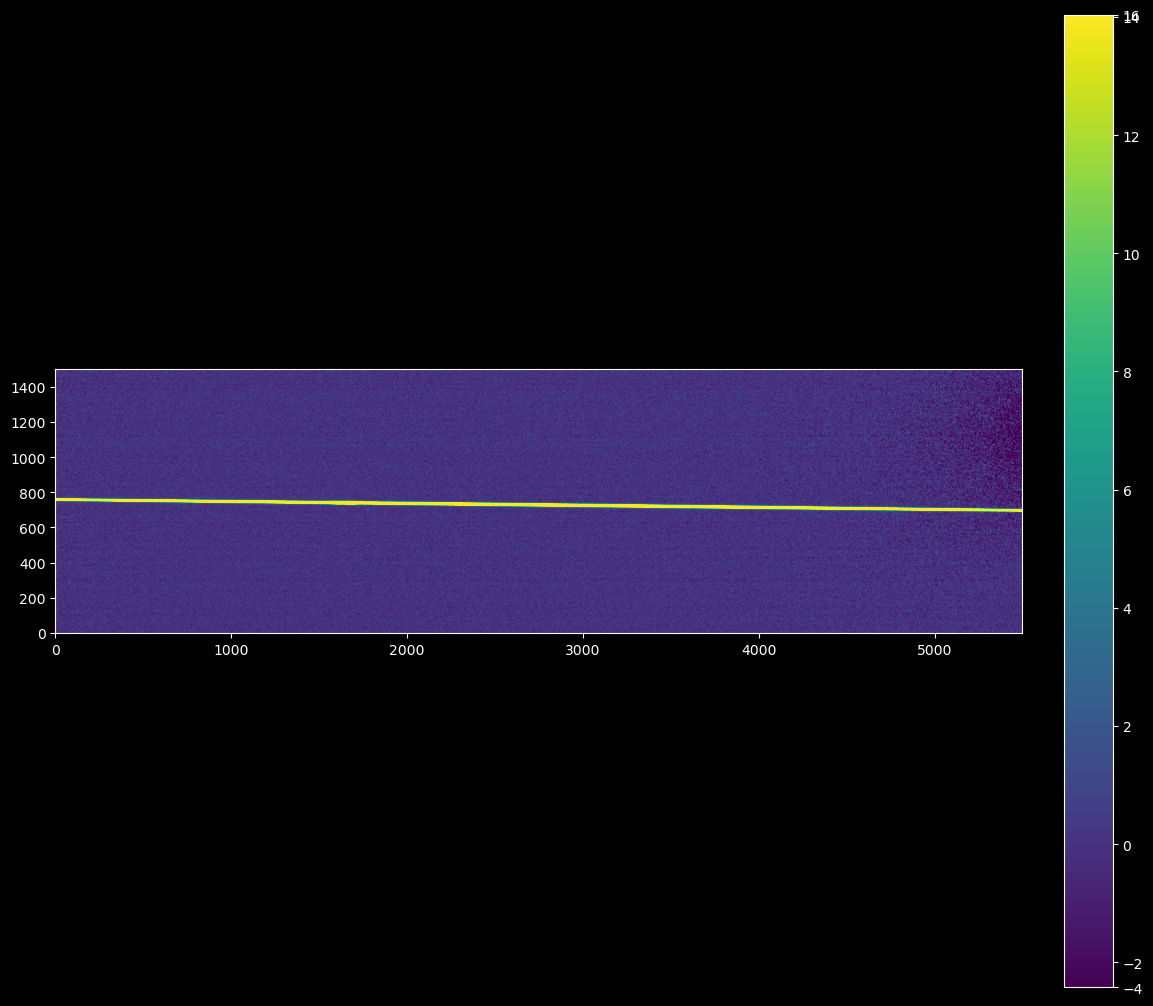

In [13]:
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.convolution import Box2DKernel

logger.info(f'master_science: min={master_science.min()}, max={master_science.max()}, avg={master_science.mean()}')

gain_corrected = gain_correct(master_science, camera_electronic_gain)
logger.info(f'gain_corrected: min={gain_corrected.min()}, max={gain_corrected.max()}, avg={gain_corrected.mean()}')

"""
master_science_clean = cosmicray_lacosmic(gain_corrected,
                                          #satlevel = 1e7,
                                          #niter = 1,
                                          gain_apply = False,
                                          sigclip = 15,
                                          cleantype = 'median',
                                          fsmode = 'median',
                                          verbose = True
                                         )
"""
#cosmicray_median(sci_master, thresh = 3, mbox=3, rbox=5, gbox=3, error_image = np.ones(sci_master.shape))
#sci_cleaned = cosmicray_median(sci_master, thresh = 3, mbox=3, rbox=5, gbox=3, error_image = np.ones(sci_master.shape))
master_science_clean = cosmicray_median(gain_corrected, #gain_corrected,
                                        thresh = 1,
                                        mbox = 3,
                                        rbox = 5, 
                                        gbox = 3,
                                        error_image = np.ones(gain_corrected.shape)
                                       )


#tophat_kernel = Box2DKernel(5)
#master_science_clean = convolve(gain_corrected, tophat_kernel)

#master_science_clean = CCDData(CCDData.add(master_science_clean, 1000 * u.electron))
                                
#print(master_science_clean.unit)
logger.info(f'master_science_clean: min={master_science_clean.min()}, max={master_science_clean.max()}, avg={master_science_clean.mean()}')
master_science_clean.write(f'{CAPTURE_DIR}{TARGET}-reduced-cosmics.fit', overwrite=True)
show_image(image = master_science_clean,  figsize=(50, ))


In [14]:
import numpy as np
logger.info(f'master_science avg uncertainty : {master_science.uncertainty.array.mean()}')
logger.info(f'master_science clean avg uncertainty : {master_science_clean.uncertainty.array.mean()}')


2024-10-02 18:36:37 [INFO] - master_science avg uncertainty : 80.08810424804688
2024-10-02 18:36:37 [INFO] - master_science clean avg uncertainty : 1.9221138954162598
